In [110]:
from tqdm import tqdm
import glob
from scipy.stats import entropy
from scipy.special import softmax
from scipy.spatial.distance import jensenshannon
import numpy as np
import pandas as pd
import json

def get_top_p_tokens(ps, p=.9):
    arg_sorted_desc = ps.argsort()[::-1]
    cumprobs = np.cumsum(ps[arg_sorted_desc])
    top_p = cumprobs[cumprobs < p].shape[0]
    top_p = max(top_p, 1)
    top_p_tokens = arg_sorted_desc[:top_p]
    return top_p_tokens

epsilon = 10e-15
def read_and_parse_logits(lines, top_p=.9):
    """Reads a file of logits, parses it and generates aggregate statistics.
    Important: don't load all the logits into memory as there are too many.
    """
    output_rows = []
    for idx, line in enumerate(lines):
        if line.strip() != '':
            datum = json.loads(line)
            if idx == 0:
                header = datum
            else:
                # additional calculations here
                is_equal = True
                if len(datum['prompted_logits']) != len(datum['instruction_model_logits']):
                    datum['instruction_model_logits'] = datum['instruction_model_logits'][:len(datum['prompted_logits'])]
                    is_equal = False

                cfg_probs = softmax(datum['cfg_logits'])
                instruct_tuned_probs = softmax(datum['instruction_model_logits'])
                vanilla_probs = softmax(datum['prompted_logits'])
                unconditional_probs = softmax(datum['unprompted_logits'])

                prompted_unprompted_l2_distance = np.linalg.norm(vanilla_probs - unconditional_probs)
                cfg_prompted_l2_distance = np.linalg.norm(cfg_probs - vanilla_probs)

                top_p_prompted_tokens = get_top_p_tokens(vanilla_probs, p=top_p)
                top_p_cfg_tokens = get_top_p_tokens(cfg_probs, p=top_p)

                output_rows.append({
                    'instruction-tuned entropy': entropy(instruct_tuned_probs),
                    'cfg entropy': entropy(cfg_probs),
                    'num cfg tokens' : len(top_p_cfg_tokens),
                    'num vanilla tokens': len(top_p_prompted_tokens),
                    'cfg prompted l2 distance': cfg_prompted_l2_distance,
                    'prompted unprompted l2 distance': prompted_unprompted_l2_distance,
                    'instruction_model_discrepancy': is_equal, # weird off-by-one error. how prevalent is it?
                    'KLD(instruct || cfg)': entropy(instruct_tuned_probs + epsilon, qk=cfg_probs + epsilon),
                    'KLD(instruct || vanilla)': entropy(instruct_tuned_probs + epsilon, qk=vanilla_probs + epsilon),
                    'JSD(instruct || cfg)': jensenshannon(p=instruct_tuned_probs + epsilon, q=cfg_probs + epsilon),
                    'JSD(instruct || vanilla)': jensenshannon(p=instruct_tuned_probs + epsilon, q=vanilla_probs + epsilon),
                })

    output_df = pd.DataFrame(output_rows)
    output_df['cfg-model'] = header['model']
    output_df['instruction-model'] = header['instruction-model']
    output_df['prompt'] = header['prompt']
    return output_df

In [111]:
p3_logits = glob.glob('../data/p3-output-dir/*')
all_lines_df = []
for logit_file in tqdm(p3_logits):
    lines = open(logit_file).read().split('\n')
    lines = list(filter(lambda x: x.strip() != '', lines))
    lines_df = read_and_parse_logits(lines)
    all_lines_df.append(lines_df)

100%|██████████| 1065/1065 [21:37<00:00,  1.22s/it]


In [112]:
full_all_lines_df = pd.concat(all_lines_df)

In [164]:
# full_all_lines_df[['JSD(instruct || cfg)', 'JSD(instruct || vanilla)']]

In [216]:
import seaborn as sns
from transformers import AutoTokenizer
red_pj_model = 'togethercomputer/RedPajama-INCITE-Base-3B-v1'
red_pj_tok = AutoTokenizer.from_pretrained(red_pj_model)
data_df = pd.read_csv('dataset_to_generate_on.csv')

In [235]:
RunningPpl().running_ppls

AttributeError: 'RunningPpl' object has no attribute 'running_ppls'

In [239]:
class RunningPpl():
    def __init__(self):
        self.running_log_probs = []
        self.running_ppls = []

    def update(self, logits, tok):
        log_probs = np.log(softmax(logits))
        self.running_log_probs.append(log_probs[tok])
        ppl = np.exp(-np.hstack(self.running_log_probs).mean())
        self.running_ppls.append(ppl)


red_pj_ppls = []
for logit_file in tqdm(p3_logits):
    lines = open(logit_file).read().split('\n')
    header = json.loads(lines[0])
    if header['model'] == red_pj_model:
        ppls_for_file = []
        prompt_candidates = data_df.loc[lambda df: df['inputs_pretokenized'] == header['prompt']]
        if prompt_candidates.shape[0] == 0:
            continue

        t_cont = prompt_candidates.iloc[0]['targets_pretokenized']
        cont_tokens = red_pj_tok.encode(t_cont)
        ppl_instruct, ppl_cfg, ppl_prompted, ppl_unprompted = RunningPpl(), RunningPpl(), RunningPpl(), RunningPpl()
        for tok, logits_line in zip(cont_tokens, lines[1:]):
            try:
                logits = json.loads(logits_line)
            except:
                continue
            ppl_instruct.update(logits['instruction_model_logits'], tok)
            ppl_cfg.update(logits['cfg_logits'], tok)
            ppl_prompted.update(logits['prompted_logits'], tok)
            ppl_unprompted.update(logits['unprompted_logits'], tok)
        red_pj_ppls.append({
            'ppls_instruct': ppl_instruct.running_ppls,
            'ppls_cfg': ppl_cfg.running_ppls,
            'ppls_prompted': ppl_prompted.running_ppls,
            'ppls_unprompted': ppl_unprompted.running_ppls,
        })

100%|██████████| 1065/1065 [09:45<00:00,  1.82it/s]


In [276]:
red_pj_ppls_df = (
    pd.DataFrame(red_pj_ppls)
    .unstack()
    .apply(pd.Series)
    .rename(columns=lambda x: f'word_idx_{x}')
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'model', 'level_1': 'doc', 'level_2': 'word_idx', 0: 'ppl'})
    .assign(word_idx=lambda df: df['word_idx'].apply(lambda x: int(x.split('_')[-1])))
)

In [294]:
import matplotlib.pyplot as plt
plt.rc('font', size=13)

Text(0, 0.5, 'Perplexity')

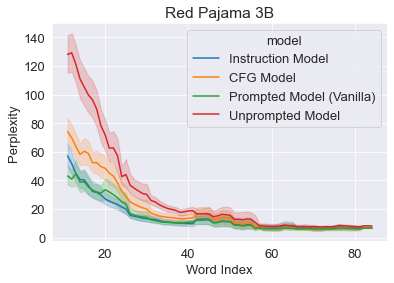

In [305]:
(   red_pj_ppls_df
        .loc[lambda df: df['word_idx'] > 10]
        .loc[lambda df: df['ppl'] < 1000] # weed out outlier bad starts/ continuations
        .assign(model=lambda df: df['model'].map({
                                        'ppls_instruct': 'Instruction Model',
                                        'ppls_cfg': 'CFG Model',
                                        'ppls_prompted': 'Prompted Model (Vanilla)',
                                        'ppls_unprompted': 'Unprompted Model'
                                }))
        .pipe(lambda df: sns.lineplot(data=df, x='word_idx', y='ppl', hue='model'))
)
plt.title('Red Pajama 3B')
plt.xlabel('Word Index')
plt.ylabel('Perplexity')

Text(0, 0.5, 'Jensen-Shannon Divergence')

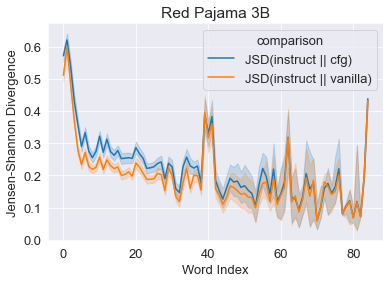

In [306]:
(
    full_all_lines_df
        .loc[lambda df: df['instruction_model_discrepancy'] == True]
        .loc[lambda df: df['cfg-model'] == 'togethercomputer/RedPajama-INCITE-Base-3B-v1']
        [['JSD(instruct || cfg)', 'JSD(instruct || vanilla)']]
        .unstack()
        .reset_index()
        .rename(columns={'level_0': 'comparison', 'level_1': 'index', 0: 'JSD'})
        .pipe(lambda df: sns.lineplot(data=df, x='index', y='JSD', hue='comparison'))
 )

plt.title('Red Pajama 3B')
plt.xlabel('Word Index')
plt.ylabel('Jensen-Shannon Divergence')

<AxesSubplot:xlabel='index', ylabel='JSD'>

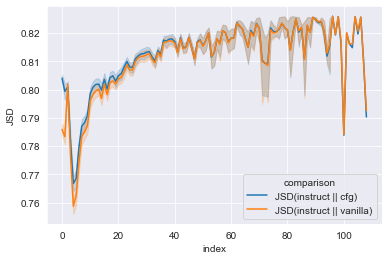

In [212]:
(full_all_lines_df
    # .loc[lambda df: df['instruction_model_discrepancy'] == True]
    .loc[lambda df: df['cfg-model'] == 'huggyllama/llama-7b']
    [['JSD(instruct || cfg)', 'JSD(instruct || vanilla)']]
    .unstack()
    .reset_index()
    .rename(columns={'level_0': 'comparison', 'level_1': 'index', 0: 'JSD'})
    .pipe(lambda df: sns.lineplot(data=df, x='index', y='JSD', hue='comparison'))
 )